In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import random
import torch.nn.functional as F
import torch.nn.functional as func
import collections
from sklearn.model_selection import train_test_split
from collections import Counter
from utils.language_utils import word_to_indices, letter_to_vec
from utils.ShakeSpeare_reduce import ShakeSpeare

import math

from models.lstm import *

v 9.0

新增client数据non-iid分布的设置

In [80]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # 解决由于多次加载 OpenMP 相关动态库而引起的冲突

In [81]:
# import sys
# print(sys.executable)

# print(torch.cuda.is_available())
# print(torch.cuda.get_device_capability())

# gpu_info = !nvidia-smi
# env = !env
# print(env)

# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.3.1
CUDA available: True


In [82]:

class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=100):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x

        return residual

# MobileNetV2（比lenet更复杂的CNN网络）网络中的线性瓶颈结构，原文中用于CIFAR-100任务
class MobileNetV2(nn.Module):

    def __init__(self, class_num=20):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(3, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x

    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))

        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1

        return nn.Sequential(*layers)

def mobilenetv2():
    return MobileNetV2()


# FedMut中采用的cnn模型
class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, start_layer_idx=0, logit=False):
        if start_layer_idx < 0:  #
            return self.mapping(x, start_layer_idx=start_layer_idx, logit=logit)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        result = {'activation' : x}
        x = x.view(-1, 16 * 5 * 5)
        result['hint'] = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        result['representation'] = x
        x = self.fc3(x)
        result['output'] = x
        return result

    def mapping(self, z_input, start_layer_idx=-1, logit=True):
        z = z_input
        z = self.fc3(z)

        result = {'output': z}
        if logit:
            result['logit'] = z
        return result
    
def cnncifar():
    return CNNCifar()



def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCifar10(nn.Module):

    def __init__(self, block, layers, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNetCifar10, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        result = {}
        x = self.layer1(x)
        result['activation1'] = x
        x = self.layer2(x)
        result['activation2'] = x
        x = self.layer3(x)
        result['activation3'] = x
        x = self.layer4(x)
        result['activation4'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        result['representation'] = x
        x = self.fc(x)
        result['output'] = x

        return result

    def mapping(self, z_input, start_layer_idx=-1, logit=True):
        z = z_input
        z = self.fc(z)

        result = {'output': z}
        if logit:
            result['logit'] = z
        return result

    def forward(self, x, start_layer_idx=0, logit=False):
        if start_layer_idx < 0:  #
            return self.mapping(x, start_layer_idx=start_layer_idx, logit=logit)
        return self._forward_impl(x)


def ResNet8(**kwargs):
    return ResNetCifar10(BasicBlock, [1, 1, 1], **kwargs)

def ResNet18_cifar10(**kwargs):
    r"""ResNet-18 model from

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return ResNetCifar10(BasicBlock, [2, 2, 2, 2], **kwargs)



def ResNet50_cifar10(**kwargs):
    r"""ResNet-50 model from

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return ResNetCifar10(Bottleneck, [3, 4, 6, 3], **kwargs)

In [83]:
# 新的测试：针对整个测试数据集的测试
def test_inference(net_glob, dataset_test):
    # testing
    acc_test, loss_test = test_img(net_glob, dataset_test)

    # print("Testing accuracy: {:.2f}".format(acc_test))

    return acc_test.item()

def test_img(net_g, datatest):
    net_g.eval()
    # testing
    # test loss代表在测试集上的平均损失（对测试数据的预测输出与真实标签的差距）
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_bc_size)
    l = len(data_loader)
    with torch.no_grad():
        for idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            log_probs = net_g(data)['output']
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [84]:
# 将CIFAR-100的100个类别转为20个类别（粒度更粗，降低任务复杂度）
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5,
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10,
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17,
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13,
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19,
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

In [85]:

# 共有6w个图像，其中5w训练，1w测试
def CIFAR100():
    '''Return Cifar100
    '''
    
    # 参考FedMut进行正则化变化
    trans_cifar100 = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )
    
    train_dataset = torchvision.datasets.CIFAR100(root='../data/CIFAR-100',
                                            train=True,
                                            transform=trans_cifar100,
                                            download=True)
    test_dataset = torchvision.datasets.CIFAR100(root='../data/CIFAR-100',
                                            train=False,
                                            transform=trans_cifar100,
                                            download=True)
    
    # 将图片转换成 numpy 数组格式，并对标签做了 coarse 处理
    total_img,total_label = [],[]
    for imgs,labels in train_dataset:
        total_img.append(imgs.numpy())
        total_label.append(labels)
    total_img = np.array(total_img)
    total_label = np.array(sparse2coarse(total_label))

    cifar = [total_img, total_label]
    
    return cifar, test_dataset

In [86]:
def get_prob(non_iid, client_num, class_num=20, iid_mode=False):
    """
    生成客户端数据分布概率矩阵
    参数:
        non_iid: Dirichlet分布参数，值越小数据越不均匀
        client_num: 客户端数量
        class_num: 类别数量
        iid_mode: 是否为IID分布模式
    返回:
        形状为(client_num, class_num)的概率矩阵
    """
    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
    
    if iid_mode:
        # IID分布 - 每个客户端对每个类别有相同的概率
        return np.ones((client_num, class_num)) / class_num
    else:
        # 非IID分布 - 使用Dirichlet分布
        return np.random.dirichlet(np.repeat(non_iid, class_num), client_num)

In [87]:
# 全部用于构建训练集
def create_data_all_train(prob, size_per_client, dataset, N=20):
    total_each_class = size_per_client * np.sum(prob, 0)
    data, label = dataset
    

    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
        random.seed(seed_num)

    # 为每个类别随机采样数据
    all_class_set = []
    for i in range(N):
        size = total_each_class[i]
        sub_data = data[label == i]
        sub_label = label[label == i]

        num_samples = int(size)
        if num_samples > len(sub_data):
            print(f"类别 {i} 的数据样本不足，采样数从 {num_samples} 调整为 {len(sub_data)}")
            num_samples = len(sub_data)
        rand_indx = np.random.choice(len(sub_data), size=num_samples, replace=False).astype(int)
        
        sub2_data, sub2_label = sub_data[rand_indx], sub_label[rand_indx]
        all_class_set.append((sub2_data, sub2_label))

    index = [0] * N
    clients = []

    for m in range(prob.shape[0]):  # 遍历客户端
        labels, images = [], []  # 训练数据

        for n in range(N):
            # 100%用于训练
            start, end = index[n], index[n] + int(prob[m][n] * size_per_client)
            image, label = all_class_set[n][0][start:end], all_class_set[n][1][start:end]

            # 记录当前类别的数据分配进度
            index[n] += int(prob[m][n] * size_per_client)

            labels.extend(label)
            images.extend(image)

        clients.append((np.array(images), np.array(labels)))

    return clients

# 80%构建训练集，20%构建测试集
def create_data(prob, size_per_client, dataset, N=20):
    total_each_class = size_per_client * np.sum(prob, 0)
    data, label = dataset

    # Modify：我之后加上的
    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
        random.seed(seed_num)

    # 为每个类别随机采样数据
    all_class_set = []
    for i in range(N):
        size = total_each_class[i]
        sub_data = data[label == i]
        sub_label = label[label == i]

        rand_indx = np.random.choice(len(sub_data), size=int(size), replace=False).astype(int)
        sub2_data, sub2_label = sub_data[rand_indx], sub_label[rand_indx]
        all_class_set.append((sub2_data, sub2_label))

    index = [0] * N
    clients, test = [], []

    for m in range(prob.shape[0]):  # 遍历客户端
        labels, images = [], []  # 训练数据
        tlabels, timages = [], [] # 测试数据

        for n in range(N):
            # 80%用于训练，20%用于测试
            # 这里的int向下取整，会导致实际的数据量比计算略小
            start, end = index[n], index[n] + int(prob[m][n] * size_per_client * 0.8)
            test_start, test_end = end, index[n] + int(prob[m][n] * size_per_client)

            image, label = all_class_set[n][0][start:end], all_class_set[n][1][start:end]
            test_image, test_label = all_class_set[n][0][test_start:test_end], all_class_set[n][1][test_start:test_end]

            # 记录当前类别的数据分配进度
            index[n] += int(prob[m][n] * size_per_client)

            labels.extend(label)
            images.extend(image)

            tlabels.extend(test_label)
            timages.extend(test_image)

        clients.append((np.array(images), np.array(labels)))
        test.append((np.array(timages), np.array(tlabels)))

    return clients, test

In [88]:

# 合并所有客户端的测试数据 （上面讲测试数据分成了不同的客户端）
# 但并没有使用，用途不明
def comb_client_test_func(client_test_data):
    comb_client_test_image = []
    comb_client_test_label = []
    for i in range(client_num):
        comb_client_test_image.extend(list(client_test_data[i][0]))
        comb_client_test_label.extend(list(client_test_data[i][1]))
    
    # 将测试图片和标签合并为 numpy 数组
    comb_client_test_image = np.array(comb_client_test_image)
    comb_client_test_label = np.array(comb_client_test_label)
    
    label_count = Counter(comb_client_test_label)
    print("测试集类别分布：")
    for label, count in sorted(label_count.items()):
        print(f"类别 {label}: {count} 个样本")
    
    return [comb_client_test_image, comb_client_test_label]

In [89]:
# 样服务器子集的函数
def select_server_subset(cifar, percentage=0.1, mode='iid', dirichlet_alpha=1.0):
    """
    从 cifar 数据集中挑选服务器数据子集（cifar 已经是 [N, C, H, W] 格式）。
    
    参数：
      - cifar: 一个列表，格式为 [images, labels]，images 形状为 [N, C, H, W]
      - percentage: 挑选比例，例如 0.1 表示取 10% 的数据
      - mode: 'iid' 表示各类别均匀采样；'non-iid' 表示使用 Dirichlet 分布采样
      - dirichlet_alpha: 当 mode 为 'non-iid' 时的 Dirichlet 分布参数
    返回：
      - subset_images: 选出的图片数组（numpy.array）
      - subset_labels: 选出的标签数组（numpy.array）
    """
    images, labels = cifar
    unique_classes = np.unique(labels)
    total_num = len(labels)
    server_total = int(total_num * percentage)
    
    selected_indices = []
    
    if mode == 'iid':
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            num_cls = int(len(cls_indices) * percentage)
            if num_cls > len(cls_indices):
                num_cls = len(cls_indices)
            sampled = np.random.choice(cls_indices, size=num_cls, replace=False)
            selected_indices.extend(sampled)
    elif mode == 'non-iid':
        num_classes = len(unique_classes)
        prob = np.random.dirichlet(np.repeat(dirichlet_alpha, num_classes))
        cls_sample_numbers = {}
        total_assigned = 0
        for i, cls in enumerate(unique_classes):
            n_cls = int(prob[i] * server_total)
            cls_sample_numbers[cls] = n_cls
            total_assigned += n_cls
        diff = server_total - total_assigned
        if diff > 0:
            for cls in np.random.choice(unique_classes, size=diff, replace=True):
                cls_sample_numbers[cls] += 1
        
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            n_sample = cls_sample_numbers[cls]
            if n_sample > len(cls_indices):
                n_sample = len(cls_indices)
            sampled = np.random.choice(cls_indices, size=n_sample, replace=False)
            selected_indices.extend(sampled)
    else:
        raise ValueError("mode 参数必须为 'iid' 或 'non-iid'")
    
    selected_indices = np.array(selected_indices)
    np.random.shuffle(selected_indices)
    
    subset_images = images[selected_indices]
    subset_labels = labels[selected_indices]
    
    return subset_images, subset_labels


In [90]:
# 本地训练并更新权重，返回更新后的模型权重、平均训练损失以及第一个迭代的梯度信息
def update_weights(model_weight, dataset, learning_rate, local_epoch):
    if origin_model == 'resnet':
        model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        model = CharLSTM().to(device)
    elif origin_model == "cnn":
        model = cnncifar().to(device)
    
    model.load_state_dict(model_weight)

    model.train()
    epoch_loss = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    if origin_model == 'resnet' or origin_model == 'cnn':
        Tensor_set = TensorDataset(torch.Tensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    elif origin_model == 'lstm':
        Tensor_set = TensorDataset(torch.LongTensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    
    data_loader = DataLoader(Tensor_set, batch_size=bc_size, shuffle=True)

    first_iter_gradient = None  # 初始化变量来保存第一个iter的梯度

    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(data_loader):
            model.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['output'], labels.long())
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item()/images.shape[0])

            # 保存第一个iter的梯度
            if iter == 0 and batch_idx == 0:
                first_iter_gradient = {}
                for name, param in model.named_parameters():
                    first_iter_gradient[name] = param.grad.clone()
                # 保存 BatchNorm 层的 running mean 和 running variance
                for name, module in model.named_modules():
                    if isinstance(module, nn.BatchNorm2d):
                        first_iter_gradient[name + '.running_mean'] = module.running_mean.clone()
                        first_iter_gradient[name + '.running_var'] = module.running_var.clone()

        epoch_loss.append(sum(batch_loss)/len(batch_loss))

    return model.state_dict(), sum(epoch_loss) / len(epoch_loss), first_iter_gradient


In [91]:
# 计算模型权重的差异，并根据学习率 lr 对权重差异进行缩放
def weight_differences(n_w, p_w, lr):
    w_diff = copy.deepcopy(n_w)
    for key in w_diff.keys():
        if 'num_batches_tracked' in key:
            continue
        w_diff[key] = (p_w[key] - n_w[key]) * lr
    return w_diff

In [92]:
# 也是本地训练，不过引入了Fed-C的权重修正机制
def update_weights_correction(model_weight, dataset, learning_rate, local_epoch, c_i, c_s):
    if origin_model == 'resnet':
        model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        model = CharLSTM().to(device)
    elif origin_model == "cnn":
        model = cnncifar().to(device)
        
    model.load_state_dict(model_weight)

    model.train()
    epoch_loss = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    if origin_model == 'resnet' or origin_model == 'cnn':
        Tensor_set = TensorDataset(torch.Tensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    elif origin_model == 'lstm':
        Tensor_set = TensorDataset(torch.LongTensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
        
    data_loader = DataLoader(Tensor_set, batch_size=bc_size, shuffle=True)

    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(data_loader):
            model.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['output'], labels.long())
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.sum().item()/images.shape[0])
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
        corrected_graident = weight_differences(c_i, c_s, learning_rate)
        orginal_model_weight = model.state_dict()
        corrected_model_weight = weight_differences(corrected_graident, orginal_model_weight, 1)  # 这里缩放权重为1
        model.load_state_dict(corrected_model_weight)

    return model.state_dict(),  sum(epoch_loss) / len(epoch_loss)

In [93]:
def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        if 'num_batches_tracked' in key:
            continue
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [94]:
# baseline: server-only
def server_only(initial_w, global_round, gamma, E):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    
    
    for round in tqdm(range(global_round)):
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        # Server side local training

                
        update_server_w, round_loss, _ = update_weights(train_w, server_data, gamma, E)
        train_w = update_server_w
        test_model.load_state_dict(train_w)
        train_loss.append(round_loss)
        
        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        # Test Accuracy
        # test_a = 0
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
        # print(test_a)
    return test_acc, train_loss

In [95]:
def fedavg(initial_w, global_round, eta, K, M):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    for round in tqdm(range(global_round)):
        local_weights, local_loss = [], []
        # Client side local training
        # if eta > 0.001:
        #     eta = eta * 0.99
        sampled_client = random.sample(range(client_num), M)
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)

        train_w = average_weights(local_weights)

        # Test Accuracy
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)
        
        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
            
        # test_a = 0
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
#         print(test_a)
    return test_acc, train_loss


In [96]:
def hybridFL(initial_w, global_round, eta, K, M):
    """
    HybridFL算法：FedAvg改进，服务器也作为一个普通客户端参与训练。
    
    参数:
    - initial_w: 初始模型权重
    - global_round: 全局训练轮数
    - eta: 学习率
    - K: 本地训练轮数
    - M: 每轮采样的客户端数量
    """
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)     # 当前全局权重
    test_acc = []                          # 保存每轮测试精度
    train_loss = []                        # 保存每轮训练损失
    
    for round in tqdm(range(global_round)):
        local_weights, local_loss = [], []  # 存储每个客户端/服务器的权重和损失

        # 随机采样 M 个客户端
        sampled_client = random.sample(range(client_num), M)

        # 客户端本地训练
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)

        # 服务器参与训练
        update_server_w, server_round_loss, _ = update_weights(train_w, server_data, eta, K)
        local_weights.append(update_server_w)   # 将服务器权重加入列表
        local_loss.append(server_round_loss)    # 将服务器损失加入列表

        # 权重聚合
        train_w = average_weights(local_weights)

        # 评估模型性能
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        
        # test_a = 0
        # for i in client_test_data:  # 遍历所有客户端测试数据
        #     ac = test_inference(test_model, i)[0]
        #     test_a += ac
        # test_a = test_a / len(client_test_data)
        # test_acc.append(test_a)
        
        # # 打印每轮的结果
        # print(f"Round {round + 1}: Test Accuracy = {test_a:.4f}, Train Loss = {loss_avg:.4f}")
    
    return test_acc, train_loss


In [97]:
def CLG_SGD(initial_w, global_round, eta, gamma, K, E, M):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    
    for round in tqdm(range(global_round)):
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        sampled_client = random.sample(range(client_num), M)
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)
        train_w = average_weights(local_weights)
        # Server side local training
    
        
        update_server_w, round_loss, _ = update_weights(train_w, server_data, gamma, E)
        train_w = update_server_w
        local_loss.append(round_loss)

        # Test Accuracy
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损失

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        # test_a = 0
        # # 遍历客户端测试数据，计算平均准确率
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
#         print(test_a)
    return test_acc, train_loss

In [98]:
# 与FedDUAP复现代码对应

def KL_divergence(p1, p2):
    """
    计算KL散度，与参考代码一致
    """
    d = 0
    for i in range(len(p1)):
        if p2[i] == 0 or p1[i] == 0:
            continue
        d += p1[i] * math.log(p1[i]/p2[i], 2)  # 使用以2为底的对数
    return d

def calculate_js_divergence(p1, p2):
    """
    计算Jensen-Shannon散度，与参考代码完全一致
    """
    # 创建中点分布p3
    p3 = []
    for i in range(len(p1)):
        p3.append((p1[i] + p2[i])/2)
    
    # 计算JS散度 = (KL(p1||p3) + KL(p2||p3))/2
    return KL_divergence(p1, p3)/2 + KL_divergence(p2, p3)/2

def ratio_combine(w1, w2, ratio=0):
    """
    将两个权重进行加权平均，ratio表示w2的占比
    对应参考代码中的ratio_combine函数
    """
    w = copy.deepcopy(w1)
    for key in w.keys():
        if 'num_batches_tracked' in key:
            continue
        w[key] = (w2[key] - w1[key]) * ratio + w1[key]
    return w

def ratio_minus(w1, P, ratio=0):
    """
    从w1减去P乘以ratio
    对应参考代码中的ratio_minus函数
    """
    w = copy.deepcopy(w1)
    for key in w.keys():
        if 'num_batches_tracked' in key:
            continue
        w[key] = w1[key] - P[key] * ratio
    return w


def FedDU_modify(initial_w, global_round, eta, gamma, K, E, M):
    """
    Federated Dynamic Update算法实现，确保与参考代码完全一致
    """
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)

    # 初始化模型权重
    train_w = copy.deepcopy(initial_w)
    test_model.load_state_dict(train_w)
    
    # 结果记录
    test_acc = []
    train_loss = []
    
    # 服务器更新的最小步长
    server_min = 0
    
    # 收集所有客户端数据标签以计算全局分布
    all_client_labels = []
    for i in range(client_num):
        all_client_labels.extend(client_data[i][1])
    all_client_labels = np.array(all_client_labels)
    
    # 获取所有数据中的唯一类别
    unique_classes = np.unique(all_client_labels)
    num_classes = len(unique_classes)
    
    # 计算全局分布 (列表格式)
    P = [0] * num_classes
    for i, cls in enumerate(unique_classes):
        P[i] = np.sum(all_client_labels == cls) / len(all_client_labels)
    
    # 获取服务器数据信息
    server_labels = np.array(server_data[1])
    n_0 = len(server_labels)  # 服务器数据量
    
    # 计算服务器分布 (列表格式)
    P_0 = [0] * num_classes
    for i, cls in enumerate(unique_classes):
        P_0[i] = np.sum(server_labels == cls) / n_0 if n_0 > 0 else 0
    
    # 计算服务器数据的非IID程度
    D_P_0 = calculate_js_divergence(P_0, P)
    
    # 输出初始设置
    print("FedDU初始设置:")
    print(f"  服务器数据量: {n_0}")
    print(f"  服务器数据非IID度: {D_P_0:.6f}")
    print(f"  衰减率: {decay_rate}")
    
    for round in tqdm(range(global_round)):
        local_weights, local_losses = [], []
        
        # 随机选择M个客户端
        sampled_clients = random.sample(range(client_num), M)
        
        # 记录当前轮次选择的客户端数据总量
        num_current = 0
        for i in sampled_clients:
            num_current += len(client_data[i][0])
        
        # 客户端本地训练
        for i in sampled_clients:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_losses.append(client_round_loss)
        
        # 聚合客户端模型
        w_t_half = average_weights(local_weights)
        
        # 计算选定客户端数据的分布 (列表格式)
        selected_client_labels = []
        for i in sampled_clients:
            selected_client_labels.extend(client_data[i][1])
        selected_client_labels = np.array(selected_client_labels)
        
        P_t_prime = [0] * num_classes
        for i, cls in enumerate(unique_classes):
            P_t_prime[i] = np.sum(selected_client_labels == cls) / len(selected_client_labels) if len(selected_client_labels) > 0 else 0
        
        # 计算选定客户端数据的非IID程度
        D_P_t_prime = calculate_js_divergence(P_t_prime, P)
        
        # 评估聚合模型的准确率
        test_model.load_state_dict(w_t_half)
        acc_t = test_inference(test_model, test_dataset) / 100.0  # 转换为[0,1]比例
        
        # 计算每个客户端的平均迭代次数
        avg_iter = (num_current * K) / (M * bc_size)
        
        # 计算alpha (动态更新系数)
        alpha = (1 - acc_t) * (n_0 * D_P_t_prime) / (n_0 * D_P_t_prime + num_current * D_P_0)
        alpha = alpha * (decay_rate ** round)
        
        # 计算服务器更新迭代次数
        server_iter = max(server_min, int(alpha * avg_iter))
        
        # 只有当alpha大于阈值时才进行服务器更新
        if alpha > 0.001:
            # 服务器数据训练实际迭代次数
            actual_iter = math.ceil(n_0 / bc_size) * E
            server_iter = min(actual_iter, server_iter)
            
            # 服务器更新
            update_server_w, round_loss, _ = update_weights(copy.deepcopy(w_t_half), server_data, gamma, E)
            local_losses.append(round_loss)
            
            # 权重更新，使用ratio_combine函数
            train_w = ratio_combine(w_t_half, update_server_w, alpha)
            
            print(f"Round {round} server fixing with iters/actual_iters/alpha {server_iter}/{actual_iter}/{alpha:.4f}")
        else:
            # 如果alpha不够大，直接使用客户端聚合模型
            train_w = copy.deepcopy(w_t_half)
            # 仍然计算服务器损失用于记录
            _, round_loss, _ = update_weights(copy.deepcopy(w_t_half), server_data, gamma, E)
            local_losses.append(round_loss)
        
        # 定期打印调试信息
        if round % 5 == 0 or round == global_round - 1:
            print(f"\nRound {round} 详情:")
            print(f"  准确率: {acc_t*100:.2f}%")
            print(f"  客户端数据量: {num_current}")
            print(f"  D(P'_t): {D_P_t_prime:.6f}")
            print(f"  D(P_0): {D_P_0:.6f}")
            print(f"  alpha: {alpha:.4f}")
            print(f"  平均迭代次数: {avg_iter:.2f}")
            print(f"  服务器迭代次数: {server_iter}")
        
        # 评估模型
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_losses) / len(local_losses)
        train_loss.append(loss_avg)
        
        # 在所有测试数据上测试
        current_acc = test_inference(test_model, test_dataset)
        test_acc.append(current_acc)
        
        if round % 10 == 0:
            print(f"Round {round}, Test Accuracy: {current_acc:.2f}%, Train Loss: {loss_avg:.4f}")
    
    return test_acc, train_loss

In [99]:
def FedMut(net_glob, global_round, eta, K, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
        
    max_rank = 0
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_agg)
        
        # Test Accuracy
        test_model.load_state_dict(w_agg)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端的平均损失

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(w_agg, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, w_agg, M, w_delta, alpha
        )

    return test_acc, train_loss   

In [100]:

# Mutation方向设置为server更新的方向
def CLG_Mut(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损失


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(update_server_w, w_agg, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


# 将mutation的方向设置为新方向（server更新之后）减去上一轮全局方向（其余不变）
def CLG_Mut_2(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)
        
        
        # copy weight to net_glob
        net_glob.load_state_dict(update_server_w)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(update_server_w, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


# 将mutation的方向设置为client训练更新的方向
def CLG_Mut_3(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)
        
        
        # copy weight to net_glob
        net_glob.load_state_dict(update_server_w)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照client训练的方向，进行mutation
        w_delta = FedSub(w_agg, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


def mutation_spread(iter, w_glob, m, w_delta, alpha):

    w_locals_new = []
    ctrl_cmd_list = []
    ctrl_rate = mut_acc_rate * (
        1.0 - min(iter * 1.0 / mut_bound, 1.0)
    )  # 论文中的βt，随着iter逐渐从β0减小到0

    # k代表模型中的参数数量，对每个参数按照client数量分配v（论文中是按照每一层分配）
    for k in w_glob.keys():
        ctrl_list = []
        for i in range(0, int(m / 2)):
            ctrl = random.random()  # 随机数，范围：[0,1)
            # 这里分ctrl感觉没什么必要，shuffle后都会随机掉
            if ctrl > 0.5:
                ctrl_list.append(1.0)
                ctrl_list.append(1.0 * (-1.0 + ctrl_rate))
            else:
                ctrl_list.append(1.0 * (-1.0 + ctrl_rate))
                ctrl_list.append(1.0)
        random.shuffle(ctrl_list)  # 打乱列表
        ctrl_cmd_list.append(ctrl_list)
    cnt = 0
    for j in range(m):
        w_sub = copy.deepcopy(w_glob)
        if not (cnt == m - 1 and m % 2 == 1):
            ind = 0
            for k in w_sub.keys():
                w_sub[k] = w_sub[k] + w_delta[k] * ctrl_cmd_list[ind][j] * alpha
                ind += 1
        cnt += 1
        w_locals_new.append(w_sub)

    return w_locals_new



# 加权平均聚合，lens代表了权重，如果没有定义就是普通平均（FedMut就每定义）
def Aggregation(w, lens):
    w_avg = None
    if lens == None:
        total_count = len(w)
        lens = []
        for i in range(len(w)):
            lens.append(1.0)
    else:
        total_count = sum(lens)

    for i in range(0, len(w)):
        if i == 0:
            w_avg = copy.deepcopy(w[0])
            for k in w_avg.keys():
                w_avg[k] = w[i][k] * lens[i]
        else:
            for k in w_avg.keys():
                w_avg[k] += w[i][k] * lens[i]

    for k in w_avg.keys():
        w_avg[k] = torch.div(w_avg[k], total_count)

    return w_avg



def FedSub(w, w_old, weight):
    w_sub = copy.deepcopy(w)
    for k in w_sub.keys():
        w_sub[k] = (w[k] - w_old[k]) * weight

    return w_sub

def delta_rank(delta_dict):
    cnt = 0
    dict_a = torch.Tensor(0)
    s = 0
    for p in delta_dict.keys():
        a = delta_dict[p]
        a = a.view(-1)
        if cnt == 0:
            dict_a = a
        else:
            dict_a = torch.cat((dict_a, a), dim=0)

        cnt += 1
        # print(sim)
    s = torch.norm(dict_a, dim=0)
    return s



In [101]:
def FedDU_Mut(net_glob, global_round, eta, gamma, K, E, M):
    """
    FedDU-Mut算法：融合CLG_Mut_2与FedDU，使用动态服务器参与度和mutation策略
    
    参数:
    - net_glob: 初始模型
    - global_round: 全局训练轮数
    - eta: 客户端学习率
    - gamma: 服务器学习率
    - K: 客户端本地训练轮数
    - E: 服务器本地训练轮数
    - M: 每轮采样的客户端数量
    """
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
    
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    # 初始化本地模型列表，用于mutation
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    # 记录每轮的最大更新幅度
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    
    # 服务器更新的最小步长
    server_min = 0
    
    # 收集所有客户端数据标签以计算全局分布
    all_client_labels = []
    for i in range(client_num):
        all_client_labels.extend(client_data[i][1])
    all_client_labels = np.array(all_client_labels)
    
    # 获取所有数据中的唯一类别
    unique_classes = np.unique(all_client_labels)
    num_classes = len(unique_classes)
    
    # 计算全局分布 (列表格式)
    P = [0] * num_classes
    for i, cls in enumerate(unique_classes):
        P[i] = np.sum(all_client_labels == cls) / len(all_client_labels)
    
    # 获取服务器数据信息
    server_labels = np.array(server_data[1])
    n_0 = len(server_labels)  # 服务器数据量
    
    # 计算服务器分布 (列表格式)
    P_0 = [0] * num_classes
    for i, cls in enumerate(unique_classes):
        P_0[i] = np.sum(server_labels == cls) / n_0 if n_0 > 0 else 0
    
    # 计算服务器数据的非IID程度
    D_P_0 = calculate_js_divergence(P_0, P)
    
    # 输出初始设置
    print("FedDU-Mut初始设置:")
    print(f"  服务器数据量: {n_0}")
    print(f"  服务器数据非IID度: {D_P_0:.6f}")
    print(f"  衰减率: {decay_rate}")
    print(f"  Mutation幅度(radius): {radius}")
    
    for round in tqdm(range(global_round)):
        # 保存当前全局模型作为基准
        w_old = copy.deepcopy(net_glob.state_dict())
        
        local_weights, local_loss = [], []
        
        # 客户端侧训练 - 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        
        # 记录当前轮次选择的客户端数据总量
        selected_client_labels = []
        num_current = 0
        
        for i, idx in enumerate(idxs_users):
            # 加载mutation后的初始模型
            net_glob.load_state_dict(w_locals[i])
            
            # 客户端本地训练
            update_client_w, client_round_loss, _ = update_weights(
                copy.deepcopy(net_glob.state_dict()), 
                client_data[idx], 
                eta, 
                K
            )
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)
            
            # 收集客户端标签和数据量
            selected_client_labels.extend(client_data[idx][1])
            num_current += len(client_data[idx][0])

        # 模型聚合 - FedAvg过程
        w_agg = Aggregation(w_locals, None)  
        
        # 将聚合模型加载到全局模型中
        net_glob.load_state_dict(w_agg)
        
        # 计算选定客户端数据的分布 (列表格式)
        selected_client_labels = np.array(selected_client_labels)
        P_t_prime = [0] * num_classes
        for i, cls in enumerate(unique_classes):
            P_t_prime[i] = np.sum(selected_client_labels == cls) / len(selected_client_labels) if len(selected_client_labels) > 0 else 0
        
        # 计算选定客户端数据的非IID程度
        D_P_t_prime = calculate_js_divergence(P_t_prime, P)
        
        # 评估聚合模型的准确率
        test_model.load_state_dict(w_agg)
        acc_t = test_inference(test_model, test_dataset) / 100.0  # 转换为[0,1]比例
        
        # 计算每个客户端的平均迭代次数
        avg_iter = (num_current * K) / (M * bc_size)
        
        # 计算alpha (动态更新系数)
        alpha = (1 - acc_t) * (n_0 * D_P_t_prime) / (n_0 * D_P_t_prime + num_current * D_P_0)
        alpha = alpha * (decay_rate ** round)
        
        # 计算服务器更新迭代次数
        server_iter = max(server_min, int(alpha * avg_iter))
        
        # 只有当alpha大于阈值时才进行服务器更新
        if alpha > 0.001:
            # 服务器数据训练实际迭代次数
            actual_iter = math.ceil(n_0 / bc_size) * E
            server_iter = min(actual_iter, server_iter)
            
            # 服务器更新
            update_server_w, round_loss, _ = update_weights(copy.deepcopy(w_agg), server_data, gamma, E)
            local_loss.append(round_loss)
            
            # 权重更新，使用ratio_combine函数
            final_model = ratio_combine(w_agg, update_server_w, alpha)
            net_glob.load_state_dict(final_model)
            
            print(f"Round {round}: Server fixing with alpha={alpha:.4f}, iters={server_iter}/{actual_iter}")
        else:
            # 如果alpha不够大，直接使用客户端聚合模型
            final_model = copy.deepcopy(w_agg)
            net_glob.load_state_dict(final_model)
            
            # 仍然计算服务器损失用于记录
            _, round_loss, _ = update_weights(copy.deepcopy(w_agg), server_data, gamma, E)
            local_loss.append(round_loss)
        
        # 测试模型性能
        test_model.load_state_dict(final_model)
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)
        
        # 在所有测试数据上测试
        current_acc = test_inference(test_model, test_dataset)
        test_acc.append(current_acc)
        
        # 按照CLG_Mut_2策略进行mutation（使用全局更新方向作为mutation方向）
        w_delta = FedSub(final_model, w_old, 1.0)
        
        # 计算模型更新w_delta的L2范数，衡量模型更新程度
        rank = delta_rank(w_delta)
        if rank > max_rank:
            max_rank = rank
            
        # Mutation扩散，为下一轮准备初始模型
        w_locals = mutation_spread(round, final_model, M, w_delta, radius)
        
        # 定期打印信息
        if round % 10 == 0:
            print(f"Round {round}: Acc={current_acc:.2f}%, Loss={loss_avg:.4f}, D_P_t={D_P_t_prime:.4f}, Alpha={alpha:.4f}")

    return test_acc, train_loss

In [102]:
# 随机性（这里暂时不采用，先固定为false）
data_random_fix = False  # 是否固定数据采样的随机性
seed_num = 42
# 新采用的全局随机性机制
random_fix = True
seed = 2

GPU = 1  # 决定使用哪个gpu 0或1
verbose = False  # 调试模式，输出一些中间信息

client_num = 100
size_per_client = 400  # 每个客户端的数据量（训练）
is_iid = False  # True表示client数据IID分布，False表示Non-IID分布
non_iid = 0.5  # Dirichlet 分布参数，数值越小数据越不均匀可根据需要调整

server_iid = True # True代表server数据iid分布，否则为Non-iid分布（默认为0.5）
server_percentage = 0.1  # 服务器端用于微调的数据比例

# 模型相关
origin_model = 'resnet' # 采用模型
dataset = 'cifar10'

momentum = 0.5
weight_decay = 0  # 模型权重衰减参数，强制参数向0靠拢（和学习率衰减不一样！）这个是给我的原始代码中就是这样（设为0表示不引入）
bc_size = 50
test_bc_size = 128
num_classes = 10  # 分别数量，CIFAR100中是20, CIFAR10是10

# 联邦训练的超参数
global_round = 100  # 全局训练轮数，可根据需要调整
eta = 0.01  # 客户端端学习率，从{0.01, 0.1, 1}中调优
gamma = 0.01  # 服务器端学习率 从{0.005， 0.05， 0.5中调有}
K = 5  # 客户端本地训练轮数，从1，3，5中选
E = 1  # 服务器本地训练轮数，从1，3，5中选
M = 10  # 每一轮抽取客户端

# FedMut中参数
radius = 5.0  # alpha，控制mutation的幅度
mut_acc_rate = 0.5  # 论文中的β0
mut_bound = 50  # Tb

# FedDU中参数
decay_rate = 0.995  # 稍微提高衰减率以降低波动


In [103]:

def set_random_seed(seed):
    """
        set random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


device = torch.device("cuda:" + str(GPU) if torch.cuda.is_available else 'cpu')

# 固定随机数
if random_fix:
    set_random_seed(seed)

if dataset == 'cifar100':
# 准备CIFAR100数据集
    cifar, test_dataset = CIFAR100()
    prob = get_prob(non_iid, client_num, class_num=20, iid_mode=is_iid)
    client_data = create_data_all_train(prob, size_per_client, cifar, N=20)   # 这里改为全部构建训练集

    # 将测试标签转换为粗类别
    test_dataset.targets = sparse2coarse(test_dataset.targets)
    test_dataset.targets = test_dataset.targets.astype(int)


    #CIFAR1--IID 挑选服务器子集：
    if server_iid:
        server_images, server_labels = select_server_subset(cifar, percentage=server_percentage, mode='iid')
    else:
        server_images, server_labels = select_server_subset(cifar, percentage=server_percentage,
                                                        mode='non-iid', dirichlet_alpha=0.5)

    init_model = ResNet18_cifar10().to(device)
    initial_w = copy.deepcopy(init_model.state_dict())
elif dataset =='shake':
    # 准备shakespeare数据集
    train_dataset = ShakeSpeare(True)
    test_dataset = ShakeSpeare(False)

    total_shake,total_label = [],[]
    for item,labels in train_dataset:
        total_shake.append(item.numpy())
        total_label.append(labels)
    total_shake = np.array(total_shake)
    total_label = np.array(total_label)

    shake = [total_shake, total_label]

    # 构建每个client的数据量
    dict_users = train_dataset.get_client_dic()

    # 统计类别数量
    unique_classes = np.unique(total_label)
    num_classes = len(unique_classes)
    print("shake数据集中类别数量：", num_classes)
    # 对于每个类别计算样本数量
    class_counts = [np.sum(total_label == cls) for cls in unique_classes]
    # 将数量转换成字符串后，用逗号隔开，并打印（只输出数字）
    print(", ".join(map(str, class_counts)))

    # 统计客户端数量
    num_clients = len(dict_users)
    print("shake数据集中客户端数量：", num_clients)

    # 构建client_data
    client_data = []
    for client in sorted(dict_users.keys()):
        indices = np.array(list(dict_users[client]), dtype=np.int64)
        client_images = total_shake[indices]
        client_labels = total_label[indices]
        client_data.append((client_images, client_labels))

    # Shake 挑选服务器子集，通过 Dirichlet 分布参数控制（例如 dirichlet_alpha=0.5）：
    if server_iid:
        server_images, server_labels = select_server_subset(shake, percentage=server_percentage,
                                                      mode='iid')
    else:
        server_images, server_labels = select_server_subset(shake, percentage=server_percentage,
                                                        mode='non-iid', dirichlet_alpha=0.5)

    # Shakespeare —— 用FedMut中提出的LSTM网络
    init_model = CharLSTM().to(device)
    initial_w = copy.deepcopy(init_model.state_dict())
elif dataset == "cifar10":
    trans_cifar10_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    trans_cifar10_val = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    
    train_dataset = torchvision.datasets.CIFAR10(
        "./data/cifar10", train=True, download=True, transform=trans_cifar10_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        "./data/cifar10", train=False, download=True, transform=trans_cifar10_val
    )
    
    # 将训练集图像数据与标签转换成 numpy 数组（与 CIFAR-100 部分类似）
    total_img, total_label = [], []
    for img, label in train_dataset:
        total_img.append(np.array(img))
        total_label.append(label)
    total_img = np.array(total_img)
    total_label = np.array(total_label)
    cifar = [total_img, total_label]

    # 使用IID参数调用get_prob
    prob = get_prob(non_iid, client_num, class_num=10, iid_mode=is_iid)
    
    # 构造每个客户端的本地数据（这里依然使用 create_data_all_train）
    client_data = create_data_all_train(prob, size_per_client, cifar, N=10)
    
    
    # 从训练集挑选出服务器训练使用的数据子集
    if server_iid:
        server_images, server_labels = select_server_subset(
            cifar, percentage=server_percentage, mode="iid"
        )
    else:
        server_images, server_labels = select_server_subset(
            cifar, percentage=server_percentage, mode="non-iid", dirichlet_alpha=0.5
        )
    
    if origin_model == 'cnn':    
        # 初始化基于 CNN 的模型，这里使用你已定义好的 CNNCifar 网络
        init_model = cnncifar().to(device)
    elif origin_model == 'resnet':
        init_model = ResNet18_cifar10().to(device)
    
    initial_w = copy.deepcopy(init_model.state_dict())


#  打印数据集情况
all_images = []
all_labels = []
for data in client_data:
    all_images.extend(data[0])
    all_labels.extend(data[1])
comb_client_data = [np.array(all_images), np.array(all_labels)]

# 输出comb_client_data情况
imgs, lbls = comb_client_data
lbls = np.array(lbls)
total_count = len(lbls)
unique_classes, counts = np.unique(lbls, return_counts=True)

num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别
class_counts = [0] * num_classes

for cls, cnt in zip(unique_classes, counts):
    class_counts[cls] = cnt

# 打印格式：Total: 总数 类别0计数 类别1计数 ... 类别19计数
print("Traning Client Total: {}".format(" ".join([str(total_count)] + [str(c) for c in class_counts])))


# 打印每个客户端训练数据情况（只输出前10个）
for i, (imgs, lbls) in enumerate(client_data[:10]):
    lbls = np.array(lbls)
    total_count = len(lbls)
    unique_classes, counts = np.unique(lbls, return_counts=True)
    
    num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别
    class_counts = [0] * num_classes
    
    for cls, cnt in zip(unique_classes, counts):
        class_counts[cls] = cnt
    # 打印格式：Client i: 总数 类别0计数 类别1计数 ... 类别19计数
    print("Client {}: {}".format(i, " ".join([str(total_count)] + [str(c) for c in class_counts])))
    

# 为了与后续代码兼容，这里将 server_data 定义为一个列表：[images, labels]
server_data = [server_images, server_labels]

# # 输出测试集数据
# total_count = len(test_dataset)
# labels = np.array(test_dataset.label)
# _, counts = np.unique(labels, return_counts=True)

# print(f"测试集总数量 {total_count}")
# print(", ".join(str(c) for c in counts))

# 打印服务器数据情况
s_imgs, s_lbls = server_data
s_lbls = np.array(s_lbls)
total_count = len(s_lbls)
unique_classes, counts = np.unique(s_lbls, return_counts=True)

num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别+1
class_counts = [0] * num_classes

for cls, cnt in zip(unique_classes, counts):
    class_counts[cls] = cnt
# 输出格式: Server: 总数 类别0计数 类别1计数 ... 类别19计数
print("Server: {}".format(" ".join([str(total_count)] + [str(c) for c in class_counts])))
# print("  前5个标签: ", lbls[:5])
# print("  前5个数据形状: ", [server_data[0][j].shape for j in range(min(5, len(server_data[0])))])


# 初始化结果存储字典
results_test_acc = {}
results_train_loss = {}

# # CLG_Mut 训练
# test_acc_CLG_Mut, train_loss_CLG_Mut = CLG_Mut(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
# results_test_acc['CLG_Mut'] = test_acc_CLG_Mut
# results_train_loss['CLG_Mut'] = train_loss_CLG_Mut

# # CLG_Mut_2 训练
# test_acc_CLG_Mut_2, train_loss_CLG_Mut_2 = CLG_Mut_2(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
# results_test_acc['CLG_Mut_2'] = test_acc_CLG_Mut_2
# results_train_loss['CLG_Mut_2'] = train_loss_CLG_Mut_2

# # CLG_Mut_3 训练
# test_acc_CLG_Mut_3, train_loss_CLG_Mut_3 = CLG_Mut_3(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
# results_test_acc['CLG_Mut_3'] = test_acc_CLG_Mut_3
# results_train_loss['CLG_Mut_3'] = train_loss_CLG_Mut_3

# # FedMut 训练
# test_acc_FedMut, train_loss_FedMut = FedMut(copy.deepcopy(init_model), global_round, eta, K, M)
# results_test_acc['FedMut'] = test_acc_FedMut
# results_train_loss['FedMut'] = train_loss_FedMut

# # Server-only 训练
# test_acc_server_only, train_loss_server_only = server_only(initial_w, global_round, gamma, E)
# results_test_acc['Server_only'] = test_acc_server_only
# results_train_loss['Server_only'] = train_loss_server_only

# # FedAvg 训练
# test_acc_fedavg, train_loss_fedavg = fedavg(initial_w, global_round, eta, K, M)
# results_test_acc['FedAvg'] = test_acc_fedavg
# results_train_loss['FedAvg'] = train_loss_fedavg

# # CLG_SGD 训练
# test_acc_CLG_SGD, train_loss_CLG_SGD = CLG_SGD(initial_w, global_round, eta, gamma, K, E, M)
# results_test_acc['CLG_SGD'] = test_acc_CLG_SGD
# results_train_loss['CLG_SGD'] = train_loss_CLG_SGD

# FedDU 训练
test_acc_CLG_SGD, train_loss_CLG_SGD = FedDU_modify(initial_w, global_round, eta, gamma, K, E, M)
results_test_acc['FedDU'] = test_acc_CLG_SGD
results_train_loss['FedDU'] = train_loss_CLG_SGD

# FedDU-Mut 训练
test_acc_FedDU_Mut, train_loss_FedDU_Mut = FedDU_Mut(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
results_test_acc['FedDU_Mut'] = test_acc_FedDU_Mut
results_train_loss['FedDU_Mut'] = train_loss_FedDU_Mut

# 如果存在至少20轮训练，则输出第二十轮的测试精度和训练损失
for algo in results_test_acc:
    if len(results_test_acc[algo]) >= 20:
        print(f"{algo} - 第二十轮测试精度: {results_test_acc[algo][19]:.2f}%, 第二十轮训练损失: {results_train_loss[algo][19]:.4f}")

print("\n")

# 打印最终训练结果
for algo in results_test_acc:
    print(f"{algo} - 最终测试精度: {results_test_acc[algo][-1]:.2f}%, 最终训练损失: {results_train_loss[algo][-1]:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Traning Client Total: 39531 4765 3370 4548 3046 4655 3655 3343 4215 4754 3180
Client 0: 396 34 20 4 10 46 2 3 141 135 1
Client 1: 395 2 2 12 24 14 49 1 185 88 18
Client 2: 395 7 11 5 2 289 36 30 3 10 2
Client 3: 395 89 74 39 20 10 55 3 36 2 67
Client 4: 395 124 82 4 32 6 16 35 37 32 27
Client 5: 395 11 2 0 16 1 8 43 228 0 86
Client 6: 395 107 54 71 4 0 9 0 0 38 112
Client 7: 395 57 56 28 25 36 0 28 115 35 15
Client 8: 394 46 11 12 0 31 2 138 127 16 11
Client 9: 396 71 57 121 0 2 43 16 54 32
Server: 5000 500 500 500 500 500 500 500 500 500 500
FedDU初始设置:
  服务器数据量: 5000
  服务器数据非IID度: 0.005182
  衰减率: 0.995


  0%|          | 0/100 [00:00<?, ?it/s]

Round 0 server fixing with iters/actual_iters/alpha 26/100/0.6724

Round 0 详情:
  准确率: 15.70%
  客户端数据量: 3955
  D(P'_t): 0.016153
  D(P_0): 0.005182
  alpha: 0.6724
  平均迭代次数: 39.55
  服务器迭代次数: 26


  1%|          | 1/100 [00:07<11:35,  7.02s/it]

Round 0, Test Accuracy: 26.60%, Train Loss: 0.0304
Round 1 server fixing with iters/actual_iters/alpha 20/100/0.5138


  2%|▏         | 2/100 [00:14<11:34,  7.08s/it]

Round 2 server fixing with iters/actual_iters/alpha 21/100/0.5448


  3%|▎         | 3/100 [00:21<11:38,  7.20s/it]

Round 3 server fixing with iters/actual_iters/alpha 20/100/0.5161


  4%|▍         | 4/100 [00:28<11:29,  7.18s/it]

Round 4 server fixing with iters/actual_iters/alpha 15/100/0.3810


  5%|▌         | 5/100 [00:35<11:20,  7.16s/it]

Round 5 server fixing with iters/actual_iters/alpha 15/100/0.3953

Round 5 详情:
  准确率: 48.33%
  客户端数据量: 3954
  D(P'_t): 0.014917
  D(P_0): 0.005182
  alpha: 0.3953
  平均迭代次数: 39.54
  服务器迭代次数: 15


  6%|▌         | 6/100 [00:42<11:12,  7.15s/it]

Round 6 server fixing with iters/actual_iters/alpha 17/100/0.4447


  7%|▋         | 7/100 [00:50<11:05,  7.15s/it]

Round 7 server fixing with iters/actual_iters/alpha 17/100/0.4517


  8%|▊         | 8/100 [00:57<10:57,  7.15s/it]

Round 8 server fixing with iters/actual_iters/alpha 16/100/0.4152


  9%|▉         | 9/100 [01:04<10:49,  7.14s/it]

Round 9 server fixing with iters/actual_iters/alpha 17/100/0.4365


 10%|█         | 10/100 [01:11<10:42,  7.14s/it]

Round 10 server fixing with iters/actual_iters/alpha 14/100/0.3749

Round 10 详情:
  准确率: 51.08%
  客户端数据量: 3955
  D(P'_t): 0.016997
  D(P_0): 0.005182
  alpha: 0.3749
  平均迭代次数: 39.55
  服务器迭代次数: 14


 11%|█         | 11/100 [01:18<10:34,  7.13s/it]

Round 10, Test Accuracy: 52.09%, Train Loss: 0.0069
Round 11 server fixing with iters/actual_iters/alpha 15/100/0.3976


 12%|█▏        | 12/100 [01:25<10:27,  7.13s/it]

Round 12 server fixing with iters/actual_iters/alpha 17/100/0.4529


 13%|█▎        | 13/100 [01:32<10:20,  7.13s/it]

Round 13 server fixing with iters/actual_iters/alpha 15/100/0.3971


 14%|█▍        | 14/100 [01:40<10:15,  7.16s/it]

Round 14 server fixing with iters/actual_iters/alpha 14/100/0.3698


 15%|█▌        | 15/100 [01:47<10:08,  7.16s/it]

Round 15 server fixing with iters/actual_iters/alpha 15/100/0.3943

Round 15 详情:
  准确率: 51.61%
  客户端数据量: 3952
  D(P'_t): 0.029602
  D(P_0): 0.005182
  alpha: 0.3943
  平均迭代次数: 39.52
  服务器迭代次数: 15


 16%|█▌        | 16/100 [01:54<10:01,  7.16s/it]

Round 16 server fixing with iters/actual_iters/alpha 16/100/0.4214


 17%|█▋        | 17/100 [02:01<09:54,  7.16s/it]

Round 17 server fixing with iters/actual_iters/alpha 12/100/0.3084


 18%|█▊        | 18/100 [02:08<09:47,  7.16s/it]

Round 18 server fixing with iters/actual_iters/alpha 13/100/0.3497


 19%|█▉        | 19/100 [02:15<09:39,  7.15s/it]

Round 19 server fixing with iters/actual_iters/alpha 15/100/0.3867


 20%|██        | 20/100 [02:22<09:32,  7.15s/it]

Round 20 server fixing with iters/actual_iters/alpha 15/100/0.3861

Round 20 详情:
  准确率: 51.75%
  客户端数据量: 3949
  D(P'_t): 0.031359
  D(P_0): 0.005182
  alpha: 0.3861
  平均迭代次数: 39.49
  服务器迭代次数: 15


 21%|██        | 21/100 [02:30<09:25,  7.16s/it]

Round 20, Test Accuracy: 53.95%, Train Loss: 0.0053
Round 21 server fixing with iters/actual_iters/alpha 13/100/0.3416


 22%|██▏       | 22/100 [02:37<09:18,  7.16s/it]

Round 22 server fixing with iters/actual_iters/alpha 15/100/0.3815


 23%|██▎       | 23/100 [02:44<09:12,  7.18s/it]

Round 23 server fixing with iters/actual_iters/alpha 13/100/0.3303


 24%|██▍       | 24/100 [02:51<09:04,  7.16s/it]

Round 24 server fixing with iters/actual_iters/alpha 14/100/0.3564


 25%|██▌       | 25/100 [02:58<08:55,  7.14s/it]

Round 25 server fixing with iters/actual_iters/alpha 14/100/0.3572

Round 25 详情:
  准确率: 52.94%
  客户端数据量: 3952
  D(P'_t): 0.025250
  D(P_0): 0.005182
  alpha: 0.3572
  平均迭代次数: 39.52
  服务器迭代次数: 14


 26%|██▌       | 26/100 [03:05<08:48,  7.15s/it]

Round 26 server fixing with iters/actual_iters/alpha 13/100/0.3531


 27%|██▋       | 27/100 [03:13<08:41,  7.14s/it]

Round 27 server fixing with iters/actual_iters/alpha 14/100/0.3576


 28%|██▊       | 28/100 [03:20<08:34,  7.14s/it]

Round 28 server fixing with iters/actual_iters/alpha 14/100/0.3580


 29%|██▉       | 29/100 [03:27<08:26,  7.13s/it]

Round 29 server fixing with iters/actual_iters/alpha 14/100/0.3677


 30%|███       | 30/100 [03:34<08:22,  7.18s/it]

Round 30 server fixing with iters/actual_iters/alpha 12/100/0.3283

Round 30 详情:
  准确率: 53.47%
  客户端数据量: 3953
  D(P'_t): 0.018671
  D(P_0): 0.005182
  alpha: 0.3283
  平均迭代次数: 39.53
  服务器迭代次数: 12


 31%|███       | 31/100 [03:41<08:18,  7.22s/it]

Round 30, Test Accuracy: 55.43%, Train Loss: 0.0035
Round 31 server fixing with iters/actual_iters/alpha 13/100/0.3462


 32%|███▏      | 32/100 [03:49<08:12,  7.24s/it]

Round 32 server fixing with iters/actual_iters/alpha 13/100/0.3483


 33%|███▎      | 33/100 [03:56<08:05,  7.25s/it]

Round 33 server fixing with iters/actual_iters/alpha 13/100/0.3344


 34%|███▍      | 34/100 [04:03<07:55,  7.21s/it]

Round 34 server fixing with iters/actual_iters/alpha 13/100/0.3347


 35%|███▌      | 35/100 [04:10<07:46,  7.18s/it]

Round 35 server fixing with iters/actual_iters/alpha 14/100/0.3665

Round 35 详情:
  准确率: 51.10%
  客户端数据量: 3956
  D(P'_t): 0.034321
  D(P_0): 0.005182
  alpha: 0.3665
  平均迭代次数: 39.56
  服务器迭代次数: 14


 36%|███▌      | 36/100 [04:17<07:39,  7.17s/it]

Round 36 server fixing with iters/actual_iters/alpha 12/100/0.3178


 37%|███▋      | 37/100 [04:25<07:33,  7.19s/it]

Round 37 server fixing with iters/actual_iters/alpha 12/100/0.3098


 38%|███▊      | 38/100 [04:32<07:24,  7.18s/it]

Round 38 server fixing with iters/actual_iters/alpha 11/100/0.2890


 39%|███▉      | 39/100 [04:39<07:16,  7.16s/it]

Round 39 server fixing with iters/actual_iters/alpha 12/100/0.3127


 40%|████      | 40/100 [04:46<07:08,  7.15s/it]

Round 40 server fixing with iters/actual_iters/alpha 12/100/0.3205

Round 40 详情:
  准确率: 55.07%
  客户端数据量: 3952
  D(P'_t): 0.027802
  D(P_0): 0.005182
  alpha: 0.3205
  平均迭代次数: 39.52
  服务器迭代次数: 12


 41%|████      | 41/100 [04:53<07:01,  7.14s/it]

Round 40, Test Accuracy: 56.52%, Train Loss: 0.0032
Round 41 server fixing with iters/actual_iters/alpha 13/100/0.3460


 42%|████▏     | 42/100 [05:00<06:53,  7.14s/it]

Round 42 server fixing with iters/actual_iters/alpha 12/100/0.3100


 43%|████▎     | 43/100 [05:07<06:46,  7.14s/it]

Round 43 server fixing with iters/actual_iters/alpha 12/100/0.3109


 44%|████▍     | 44/100 [05:14<06:39,  7.13s/it]

Round 44 server fixing with iters/actual_iters/alpha 11/100/0.2854


 45%|████▌     | 45/100 [05:22<06:32,  7.13s/it]

Round 45 server fixing with iters/actual_iters/alpha 12/100/0.3240

Round 45 详情:
  准确率: 55.33%
  客户端数据量: 3954
  D(P'_t): 0.040800
  D(P_0): 0.005182
  alpha: 0.3240
  平均迭代次数: 39.54
  服务器迭代次数: 12


 46%|████▌     | 46/100 [05:29<06:25,  7.14s/it]

Round 46 server fixing with iters/actual_iters/alpha 11/100/0.2981


 47%|████▋     | 47/100 [05:36<06:18,  7.13s/it]

Round 47 server fixing with iters/actual_iters/alpha 12/100/0.3141


 48%|████▊     | 48/100 [05:43<06:10,  7.13s/it]

Round 48 server fixing with iters/actual_iters/alpha 10/100/0.2690


 49%|████▉     | 49/100 [05:50<06:03,  7.13s/it]

Round 49 server fixing with iters/actual_iters/alpha 12/100/0.3088


 50%|█████     | 50/100 [05:57<05:56,  7.13s/it]

Round 50 server fixing with iters/actual_iters/alpha 11/100/0.3005

Round 50 详情:
  准确率: 55.58%
  客户端数据量: 3955
  D(P'_t): 0.027209
  D(P_0): 0.005182
  alpha: 0.3005
  平均迭代次数: 39.55
  服务器迭代次数: 11


 51%|█████     | 51/100 [06:04<05:49,  7.13s/it]

Round 50, Test Accuracy: 56.98%, Train Loss: 0.0027
Round 51 server fixing with iters/actual_iters/alpha 11/100/0.2998


 52%|█████▏    | 52/100 [06:12<05:42,  7.13s/it]

Round 52 server fixing with iters/actual_iters/alpha 12/100/0.3136


 53%|█████▎    | 53/100 [06:19<05:34,  7.13s/it]

Round 53 server fixing with iters/actual_iters/alpha 12/100/0.3046


 54%|█████▍    | 54/100 [06:26<05:28,  7.14s/it]

Round 54 server fixing with iters/actual_iters/alpha 10/100/0.2644


 55%|█████▌    | 55/100 [06:33<05:23,  7.19s/it]

Round 55 server fixing with iters/actual_iters/alpha 10/100/0.2571

Round 55 详情:
  准确率: 56.66%
  客户端数据量: 3961
  D(P'_t): 0.014683
  D(P_0): 0.005182
  alpha: 0.2571
  平均迭代次数: 39.61
  服务器迭代次数: 10


 56%|█████▌    | 56/100 [06:40<05:16,  7.20s/it]

Round 56 server fixing with iters/actual_iters/alpha 11/100/0.2903


 57%|█████▋    | 57/100 [06:47<05:08,  7.18s/it]

Round 57 server fixing with iters/actual_iters/alpha 11/100/0.2863


 58%|█████▊    | 58/100 [06:55<05:01,  7.17s/it]

Round 58 server fixing with iters/actual_iters/alpha 10/100/0.2609


 59%|█████▉    | 59/100 [07:02<04:53,  7.16s/it]

Round 59 server fixing with iters/actual_iters/alpha 10/100/0.2779


 60%|██████    | 60/100 [07:09<04:46,  7.15s/it]

Round 60 server fixing with iters/actual_iters/alpha 8/100/0.2230

Round 60 详情:
  准确率: 56.65%
  客户端数据量: 3957
  D(P'_t): 0.009337
  D(P_0): 0.005182
  alpha: 0.2230
  平均迭代次数: 39.57
  服务器迭代次数: 8


 61%|██████    | 61/100 [07:16<04:39,  7.18s/it]

Round 60, Test Accuracy: 57.64%, Train Loss: 0.0021
Round 61 server fixing with iters/actual_iters/alpha 9/100/0.2380


 62%|██████▏   | 62/100 [07:23<04:32,  7.18s/it]

Round 62 server fixing with iters/actual_iters/alpha 11/100/0.2964


 63%|██████▎   | 63/100 [07:30<04:25,  7.16s/it]

Round 63 server fixing with iters/actual_iters/alpha 11/100/0.2907


 64%|██████▍   | 64/100 [07:38<04:17,  7.16s/it]

Round 64 server fixing with iters/actual_iters/alpha 11/100/0.2916


 65%|██████▌   | 65/100 [07:45<04:10,  7.16s/it]

Round 65 server fixing with iters/actual_iters/alpha 10/100/0.2687

Round 65 详情:
  准确率: 56.68%
  客户端数据量: 3952
  D(P'_t): 0.024969
  D(P_0): 0.005182
  alpha: 0.2687
  平均迭代次数: 39.52
  服务器迭代次数: 10


 66%|██████▌   | 66/100 [07:52<04:03,  7.15s/it]

Round 66 server fixing with iters/actual_iters/alpha 8/100/0.2070


 67%|██████▋   | 67/100 [07:59<03:55,  7.14s/it]

Round 67 server fixing with iters/actual_iters/alpha 11/100/0.2828


 68%|██████▊   | 68/100 [08:06<03:48,  7.13s/it]

Round 68 server fixing with iters/actual_iters/alpha 9/100/0.2468


 69%|██████▉   | 69/100 [08:13<03:41,  7.14s/it]

Round 69 server fixing with iters/actual_iters/alpha 9/100/0.2331


 70%|███████   | 70/100 [08:20<03:33,  7.13s/it]

Round 70 server fixing with iters/actual_iters/alpha 9/100/0.2297

Round 70 详情:
  准确率: 56.53%
  客户端数据量: 3955
  D(P'_t): 0.012323
  D(P_0): 0.005182
  alpha: 0.2297
  平均迭代次数: 39.55
  服务器迭代次数: 9


 71%|███████   | 71/100 [08:27<03:26,  7.13s/it]

Round 70, Test Accuracy: 57.56%, Train Loss: 0.0023
Round 71 server fixing with iters/actual_iters/alpha 10/100/0.2539


 72%|███████▏  | 72/100 [08:35<03:19,  7.12s/it]

Round 72 server fixing with iters/actual_iters/alpha 9/100/0.2500


 73%|███████▎  | 73/100 [08:42<03:12,  7.12s/it]

Round 73 server fixing with iters/actual_iters/alpha 10/100/0.2652


 74%|███████▍  | 74/100 [08:49<03:05,  7.12s/it]

Round 74 server fixing with iters/actual_iters/alpha 11/100/0.2830


 75%|███████▌  | 75/100 [08:56<02:58,  7.12s/it]

Round 75 server fixing with iters/actual_iters/alpha 10/100/0.2731

Round 75 详情:
  准确率: 55.85%
  客户端数据量: 3946
  D(P'_t): 0.037136
  D(P_0): 0.005182
  alpha: 0.2731
  平均迭代次数: 39.46
  服务器迭代次数: 10


 76%|███████▌  | 76/100 [09:03<02:51,  7.14s/it]

Round 76 server fixing with iters/actual_iters/alpha 10/100/0.2751


 77%|███████▋  | 77/100 [09:10<02:44,  7.14s/it]

Round 77 server fixing with iters/actual_iters/alpha 10/100/0.2593


 78%|███████▊  | 78/100 [09:17<02:37,  7.15s/it]

Round 78 server fixing with iters/actual_iters/alpha 9/100/0.2463


 79%|███████▉  | 79/100 [09:25<02:30,  7.15s/it]

Round 79 server fixing with iters/actual_iters/alpha 10/100/0.2544


 80%|████████  | 80/100 [09:32<02:23,  7.16s/it]

Round 80 server fixing with iters/actual_iters/alpha 8/100/0.2240

Round 80 详情:
  准确率: 58.00%
  客户端数据量: 3953
  D(P'_t): 0.016040
  D(P_0): 0.005182
  alpha: 0.2240
  平均迭代次数: 39.53
  服务器迭代次数: 8


 81%|████████  | 81/100 [09:39<02:16,  7.19s/it]

Round 80, Test Accuracy: 58.31%, Train Loss: 0.0018
Round 81 server fixing with iters/actual_iters/alpha 8/100/0.2177


 82%|████████▏ | 82/100 [09:46<02:09,  7.18s/it]

Round 82 server fixing with iters/actual_iters/alpha 9/100/0.2504


 83%|████████▎ | 83/100 [09:53<02:02,  7.18s/it]

Round 83 server fixing with iters/actual_iters/alpha 7/100/0.1804


 84%|████████▍ | 84/100 [10:01<01:55,  7.24s/it]

Round 84 server fixing with iters/actual_iters/alpha 9/100/0.2381


 85%|████████▌ | 85/100 [10:08<01:48,  7.26s/it]

Round 85 server fixing with iters/actual_iters/alpha 10/100/0.2671

Round 85 详情:
  准确率: 55.91%
  客户端数据量: 3955
  D(P'_t): 0.052565
  D(P_0): 0.005182
  alpha: 0.2671
  平均迭代次数: 39.55
  服务器迭代次数: 10


 86%|████████▌ | 86/100 [10:15<01:41,  7.27s/it]

Round 86 server fixing with iters/actual_iters/alpha 9/100/0.2389


 87%|████████▋ | 87/100 [10:23<01:34,  7.28s/it]

Round 87 server fixing with iters/actual_iters/alpha 9/100/0.2404


 88%|████████▊ | 88/100 [10:30<01:26,  7.24s/it]

Round 88 server fixing with iters/actual_iters/alpha 8/100/0.2259


 89%|████████▉ | 89/100 [10:37<01:18,  7.16s/it]

Round 89 server fixing with iters/actual_iters/alpha 8/100/0.2159


 90%|█████████ | 90/100 [10:44<01:11,  7.15s/it]

Round 90 server fixing with iters/actual_iters/alpha 7/100/0.1910

Round 90 详情:
  准确率: 58.33%
  客户端数据量: 3953
  D(P'_t): 0.010517
  D(P_0): 0.005182
  alpha: 0.1910
  平均迭代次数: 39.53
  服务器迭代次数: 7


 91%|█████████ | 91/100 [10:51<01:04,  7.15s/it]

Round 90, Test Accuracy: 58.69%, Train Loss: 0.0013
Round 91 server fixing with iters/actual_iters/alpha 8/100/0.2195


 92%|█████████▏| 92/100 [10:58<00:57,  7.18s/it]

Round 92 server fixing with iters/actual_iters/alpha 7/100/0.1948


 93%|█████████▎| 93/100 [11:06<00:50,  7.19s/it]

Round 93 server fixing with iters/actual_iters/alpha 9/100/0.2312


 94%|█████████▍| 94/100 [11:13<00:43,  7.17s/it]

Round 94 server fixing with iters/actual_iters/alpha 9/100/0.2414


 95%|█████████▌| 95/100 [11:20<00:35,  7.16s/it]

Round 95 server fixing with iters/actual_iters/alpha 6/100/0.1704

Round 95 详情:
  准确率: 57.86%
  客户端数据量: 3956
  D(P'_t): 0.007644
  D(P_0): 0.005182
  alpha: 0.1704
  平均迭代次数: 39.56
  服务器迭代次数: 6


 96%|█████████▌| 96/100 [11:27<00:28,  7.16s/it]

Round 96 server fixing with iters/actual_iters/alpha 7/100/0.1857


 97%|█████████▋| 97/100 [11:34<00:21,  7.15s/it]

Round 97 server fixing with iters/actual_iters/alpha 8/100/0.2205


 98%|█████████▊| 98/100 [11:41<00:14,  7.15s/it]

Round 98 server fixing with iters/actual_iters/alpha 8/100/0.2173


 99%|█████████▉| 99/100 [11:48<00:07,  7.15s/it]

Round 99 server fixing with iters/actual_iters/alpha 8/100/0.2195

Round 99 详情:
  准确率: 56.61%
  客户端数据量: 3958
  D(P'_t): 0.020142
  D(P_0): 0.005182
  alpha: 0.2195
  平均迭代次数: 39.58
  服务器迭代次数: 8


100%|██████████| 100/100 [11:56<00:00,  7.16s/it]


FedDU-Mut初始设置:
  服务器数据量: 5000
  服务器数据非IID度: 0.005182
  衰减率: 0.995
  Mutation幅度(radius): 5.0


  0%|          | 0/100 [00:00<?, ?it/s]

Round 0: Server fixing with alpha=0.7080, iters=27/100


  1%|          | 1/100 [00:07<11:57,  7.24s/it]

Round 0: Acc=25.86%, Loss=0.0274, D_P_t=0.0246, Alpha=0.7080
Round 1: Server fixing with alpha=0.7138, iters=28/100


  2%|▏         | 2/100 [00:14<11:51,  7.26s/it]

Round 2: Server fixing with alpha=0.5080, iters=20/100


  3%|▎         | 3/100 [00:21<11:44,  7.27s/it]

Round 3: Server fixing with alpha=0.5800, iters=22/100


  4%|▍         | 4/100 [00:29<11:42,  7.32s/it]

Round 4: Server fixing with alpha=0.5955, iters=23/100


  5%|▌         | 5/100 [00:36<11:35,  7.32s/it]

Round 5: Server fixing with alpha=0.6429, iters=25/100


  6%|▌         | 6/100 [00:43<11:26,  7.31s/it]

Round 6: Server fixing with alpha=0.6346, iters=25/100


  7%|▋         | 7/100 [00:51<11:18,  7.30s/it]

Round 7: Server fixing with alpha=0.6165, iters=24/100


  8%|▊         | 8/100 [00:58<11:11,  7.30s/it]

Round 8: Server fixing with alpha=0.6274, iters=24/100


  9%|▉         | 9/100 [01:05<11:04,  7.30s/it]

Round 9: Server fixing with alpha=0.5472, iters=21/100


 10%|█         | 10/100 [01:12<10:56,  7.30s/it]

Round 10: Server fixing with alpha=0.4674, iters=18/100


 11%|█         | 11/100 [01:20<10:49,  7.30s/it]

Round 10: Acc=48.60%, Loss=0.0138, D_P_t=0.0118, Alpha=0.4674
Round 11: Server fixing with alpha=0.4801, iters=18/100


 12%|█▏        | 12/100 [01:27<10:42,  7.30s/it]

Round 12: Server fixing with alpha=0.5147, iters=20/100


 13%|█▎        | 13/100 [01:34<10:34,  7.29s/it]

Round 13: Server fixing with alpha=0.4963, iters=19/100


 14%|█▍        | 14/100 [01:42<10:26,  7.29s/it]

Round 14: Server fixing with alpha=0.4037, iters=15/100


 15%|█▌        | 15/100 [01:49<10:22,  7.32s/it]

Round 15: Server fixing with alpha=0.4363, iters=17/100


 16%|█▌        | 16/100 [01:56<10:13,  7.31s/it]

Round 16: Server fixing with alpha=0.3741, iters=14/100


 17%|█▋        | 17/100 [02:04<10:06,  7.31s/it]

Round 17: Server fixing with alpha=0.3613, iters=14/100


 18%|█▊        | 18/100 [02:11<09:58,  7.30s/it]

Round 18: Server fixing with alpha=0.3279, iters=12/100


 19%|█▉        | 19/100 [02:18<09:49,  7.28s/it]

Round 19: Server fixing with alpha=0.3269, iters=12/100


 20%|██        | 20/100 [02:25<09:42,  7.28s/it]

Round 20: Server fixing with alpha=0.2911, iters=11/100


 21%|██        | 21/100 [02:33<09:35,  7.28s/it]

Round 20: Acc=61.94%, Loss=0.0056, D_P_t=0.0198, Alpha=0.2911
Round 21: Server fixing with alpha=0.2924, iters=11/100


 22%|██▏       | 22/100 [02:40<09:27,  7.28s/it]

Round 22: Server fixing with alpha=0.2989, iters=11/100


 23%|██▎       | 23/100 [02:47<09:20,  7.28s/it]

Round 23: Server fixing with alpha=0.3016, iters=11/100


 24%|██▍       | 24/100 [02:55<09:13,  7.28s/it]

Round 24: Server fixing with alpha=0.2237, iters=8/100


 25%|██▌       | 25/100 [03:02<09:06,  7.28s/it]

Round 25: Server fixing with alpha=0.2850, iters=11/100


 26%|██▌       | 26/100 [03:09<08:59,  7.28s/it]

Round 26: Server fixing with alpha=0.2903, iters=11/100


 27%|██▋       | 27/100 [03:16<08:53,  7.31s/it]

Round 27: Server fixing with alpha=0.2658, iters=10/100


 28%|██▊       | 28/100 [03:24<08:46,  7.31s/it]

Round 28: Server fixing with alpha=0.2909, iters=11/100


 29%|██▉       | 29/100 [03:31<08:38,  7.30s/it]

Round 29: Server fixing with alpha=0.2682, iters=10/100


 30%|███       | 30/100 [03:38<08:30,  7.29s/it]

Round 30: Server fixing with alpha=0.2957, iters=11/100


 31%|███       | 31/100 [03:46<08:23,  7.30s/it]

Round 30: Acc=63.66%, Loss=0.0028, D_P_t=0.0461, Alpha=0.2957
Round 31: Server fixing with alpha=0.2523, iters=9/100


 32%|███▏      | 32/100 [03:53<08:16,  7.29s/it]

Round 32: Server fixing with alpha=0.2375, iters=9/100


 33%|███▎      | 33/100 [04:00<08:08,  7.29s/it]

Round 33: Server fixing with alpha=0.2360, iters=9/100


 34%|███▍      | 34/100 [04:07<08:00,  7.29s/it]

Round 34: Server fixing with alpha=0.2767, iters=10/100


 35%|███▌      | 35/100 [04:15<07:54,  7.29s/it]

Round 35: Server fixing with alpha=0.2673, iters=10/100


 36%|███▌      | 36/100 [04:22<07:46,  7.29s/it]

Round 36: Server fixing with alpha=0.2740, iters=10/100


 37%|███▋      | 37/100 [04:29<07:39,  7.29s/it]

Round 37: Server fixing with alpha=0.2665, iters=10/100


 38%|███▊      | 38/100 [04:37<07:33,  7.32s/it]

Round 38: Server fixing with alpha=0.1994, iters=7/100


 39%|███▉      | 39/100 [04:44<07:25,  7.31s/it]

Round 39: Server fixing with alpha=0.2679, iters=10/100


 40%|████      | 40/100 [04:51<07:18,  7.31s/it]

Round 40: Server fixing with alpha=0.2355, iters=9/100


 41%|████      | 41/100 [04:59<07:10,  7.30s/it]

Round 40: Acc=64.72%, Loss=0.0030, D_P_t=0.0177, Alpha=0.2355
Round 41: Server fixing with alpha=0.2630, iters=10/100


 42%|████▏     | 42/100 [05:06<07:02,  7.29s/it]

Round 42: Server fixing with alpha=0.2514, iters=9/100


 43%|████▎     | 43/100 [05:13<06:55,  7.30s/it]

Round 43: Server fixing with alpha=0.2440, iters=9/100


 44%|████▍     | 44/100 [05:20<06:48,  7.29s/it]

Round 44: Server fixing with alpha=0.2615, iters=10/100


 45%|████▌     | 45/100 [05:28<06:41,  7.30s/it]

Round 45: Server fixing with alpha=0.2364, iters=9/100


 46%|████▌     | 46/100 [05:35<06:34,  7.30s/it]

Round 46: Server fixing with alpha=0.2687, iters=10/100


 47%|████▋     | 47/100 [05:42<06:26,  7.30s/it]

Round 47: Server fixing with alpha=0.2458, iters=9/100


 48%|████▊     | 48/100 [05:50<06:19,  7.29s/it]

Round 48: Server fixing with alpha=0.2422, iters=9/100


 49%|████▉     | 49/100 [05:57<06:11,  7.29s/it]

Round 49: Server fixing with alpha=0.2802, iters=11/100


 50%|█████     | 50/100 [06:04<06:06,  7.32s/it]

Round 50: Server fixing with alpha=0.2417, iters=9/100


 51%|█████     | 51/100 [06:12<05:58,  7.31s/it]

Round 50: Acc=64.26%, Loss=0.0033, D_P_t=0.0250, Alpha=0.2417
Round 51: Server fixing with alpha=0.2397, iters=9/100


 52%|█████▏    | 52/100 [06:19<05:50,  7.30s/it]

Round 52: Server fixing with alpha=0.2276, iters=9/100


 53%|█████▎    | 53/100 [06:26<05:43,  7.30s/it]

Round 53: Server fixing with alpha=0.2589, iters=10/100


 54%|█████▍    | 54/100 [06:34<05:37,  7.33s/it]

Round 54: Server fixing with alpha=0.2486, iters=9/100


 55%|█████▌    | 55/100 [06:41<05:29,  7.32s/it]

Round 55: Server fixing with alpha=0.2272, iters=8/100


 56%|█████▌    | 56/100 [06:48<05:21,  7.31s/it]

Round 56: Server fixing with alpha=0.1792, iters=7/100


 57%|█████▋    | 57/100 [06:55<05:14,  7.31s/it]

Round 57: Server fixing with alpha=0.2321, iters=9/100


 58%|█████▊    | 58/100 [07:03<05:06,  7.31s/it]

Round 58: Server fixing with alpha=0.2288, iters=9/100


 59%|█████▉    | 59/100 [07:10<04:59,  7.30s/it]

Round 59: Server fixing with alpha=0.2381, iters=9/100


 60%|██████    | 60/100 [07:17<04:51,  7.29s/it]

Round 60: Server fixing with alpha=0.2325, iters=9/100


 61%|██████    | 61/100 [07:25<04:44,  7.29s/it]

Round 60: Acc=63.93%, Loss=0.0030, D_P_t=0.0238, Alpha=0.2325
Round 61: Server fixing with alpha=0.2297, iters=9/100


 62%|██████▏   | 62/100 [07:32<04:38,  7.33s/it]

Round 62: Server fixing with alpha=0.2419, iters=9/100


 63%|██████▎   | 63/100 [07:39<04:30,  7.32s/it]

Round 63: Server fixing with alpha=0.2232, iters=8/100


 64%|██████▍   | 64/100 [07:47<04:22,  7.30s/it]

Round 64: Server fixing with alpha=0.2202, iters=8/100


 65%|██████▌   | 65/100 [07:54<04:15,  7.29s/it]

Round 65: Server fixing with alpha=0.2115, iters=8/100


 66%|██████▌   | 66/100 [08:01<04:08,  7.30s/it]

Round 66: Server fixing with alpha=0.1956, iters=7/100


 67%|██████▋   | 67/100 [08:08<04:00,  7.29s/it]

Round 67: Server fixing with alpha=0.2212, iters=8/100


 68%|██████▊   | 68/100 [08:16<03:53,  7.29s/it]

Round 68: Server fixing with alpha=0.2408, iters=9/100


 69%|██████▉   | 69/100 [08:23<03:47,  7.33s/it]

Round 69: Server fixing with alpha=0.1965, iters=7/100


 70%|███████   | 70/100 [08:31<03:41,  7.37s/it]

Round 70: Server fixing with alpha=0.1885, iters=7/100


 71%|███████   | 71/100 [08:38<03:33,  7.35s/it]

Round 70: Acc=65.14%, Loss=0.0026, D_P_t=0.0129, Alpha=0.1885
Round 71: Server fixing with alpha=0.1455, iters=5/100


 72%|███████▏  | 72/100 [08:45<03:25,  7.33s/it]

Round 72: Server fixing with alpha=0.2242, iters=8/100


 73%|███████▎  | 73/100 [08:53<03:18,  7.36s/it]

Round 73: Server fixing with alpha=0.2021, iters=7/100


 74%|███████▍  | 74/100 [09:00<03:11,  7.36s/it]

Round 74: Server fixing with alpha=0.1947, iters=7/100


 75%|███████▌  | 75/100 [09:07<03:03,  7.32s/it]

Round 75: Server fixing with alpha=0.1941, iters=7/100


 76%|███████▌  | 76/100 [09:14<02:52,  7.19s/it]

Round 76: Server fixing with alpha=0.2320, iters=9/100


 77%|███████▋  | 77/100 [09:21<02:46,  7.22s/it]

Round 77: Server fixing with alpha=0.2011, iters=7/100


 78%|███████▊  | 78/100 [09:29<02:39,  7.25s/it]

Round 78: Server fixing with alpha=0.1917, iters=7/100


 79%|███████▉  | 79/100 [09:36<02:33,  7.30s/it]

Round 79: Server fixing with alpha=0.1661, iters=6/100


 80%|████████  | 80/100 [09:43<02:25,  7.29s/it]

Round 80: Server fixing with alpha=0.2056, iters=8/100


 81%|████████  | 81/100 [09:51<02:18,  7.29s/it]

Round 80: Acc=64.75%, Loss=0.0018, D_P_t=0.0265, Alpha=0.2056
Round 81: Server fixing with alpha=0.2035, iters=8/100


 82%|████████▏ | 82/100 [09:58<02:11,  7.29s/it]

Round 82: Server fixing with alpha=0.1987, iters=7/100


 83%|████████▎ | 83/100 [10:05<02:03,  7.29s/it]

Round 83: Server fixing with alpha=0.2067, iters=8/100


 84%|████████▍ | 84/100 [10:13<01:57,  7.31s/it]

Round 84: Server fixing with alpha=0.1968, iters=7/100


 85%|████████▌ | 85/100 [10:20<01:49,  7.31s/it]

Round 85: Server fixing with alpha=0.1863, iters=7/100


 86%|████████▌ | 86/100 [10:27<01:42,  7.35s/it]

Round 86: Server fixing with alpha=0.2184, iters=8/100


 87%|████████▋ | 87/100 [10:35<01:35,  7.37s/it]

Round 87: Server fixing with alpha=0.1962, iters=7/100


 88%|████████▊ | 88/100 [10:42<01:28,  7.36s/it]

Round 88: Server fixing with alpha=0.1641, iters=6/100


 89%|████████▉ | 89/100 [10:49<01:20,  7.34s/it]

Round 89: Server fixing with alpha=0.1887, iters=7/100


 90%|█████████ | 90/100 [10:57<01:13,  7.32s/it]

Round 90: Server fixing with alpha=0.1640, iters=6/100


 91%|█████████ | 91/100 [11:04<01:05,  7.31s/it]

Round 90: Acc=65.44%, Loss=0.0020, D_P_t=0.0118, Alpha=0.1640
Round 91: Server fixing with alpha=0.1867, iters=7/100


 92%|█████████▏| 92/100 [11:11<00:58,  7.30s/it]

Round 92: Server fixing with alpha=0.2076, iters=8/100


 93%|█████████▎| 93/100 [11:19<00:51,  7.29s/it]

Round 93: Server fixing with alpha=0.2032, iters=8/100


 94%|█████████▍| 94/100 [11:26<00:43,  7.29s/it]

Round 94: Server fixing with alpha=0.1897, iters=7/100


 95%|█████████▌| 95/100 [11:33<00:36,  7.28s/it]

Round 95: Server fixing with alpha=0.2011, iters=7/100


 96%|█████████▌| 96/100 [11:41<00:29,  7.32s/it]

Round 96: Server fixing with alpha=0.1838, iters=7/100


 97%|█████████▋| 97/100 [11:48<00:21,  7.30s/it]

Round 97: Server fixing with alpha=0.1965, iters=7/100


 98%|█████████▊| 98/100 [11:55<00:14,  7.30s/it]

Round 98: Server fixing with alpha=0.1894, iters=7/100


 99%|█████████▉| 99/100 [12:02<00:07,  7.29s/it]

Round 99: Server fixing with alpha=0.1841, iters=7/100


100%|██████████| 100/100 [12:10<00:00,  7.30s/it]

FedDU - 第二十轮测试精度: 53.76%, 第二十轮训练损失: 0.0046
FedDU_Mut - 第二十轮测试精度: 61.61%, 第二十轮训练损失: 0.0065


FedDU - 最终测试精度: 57.27%, 最终训练损失: 0.0011
FedDU_Mut - 最终测试精度: 65.21%, 最终训练损失: 0.0024


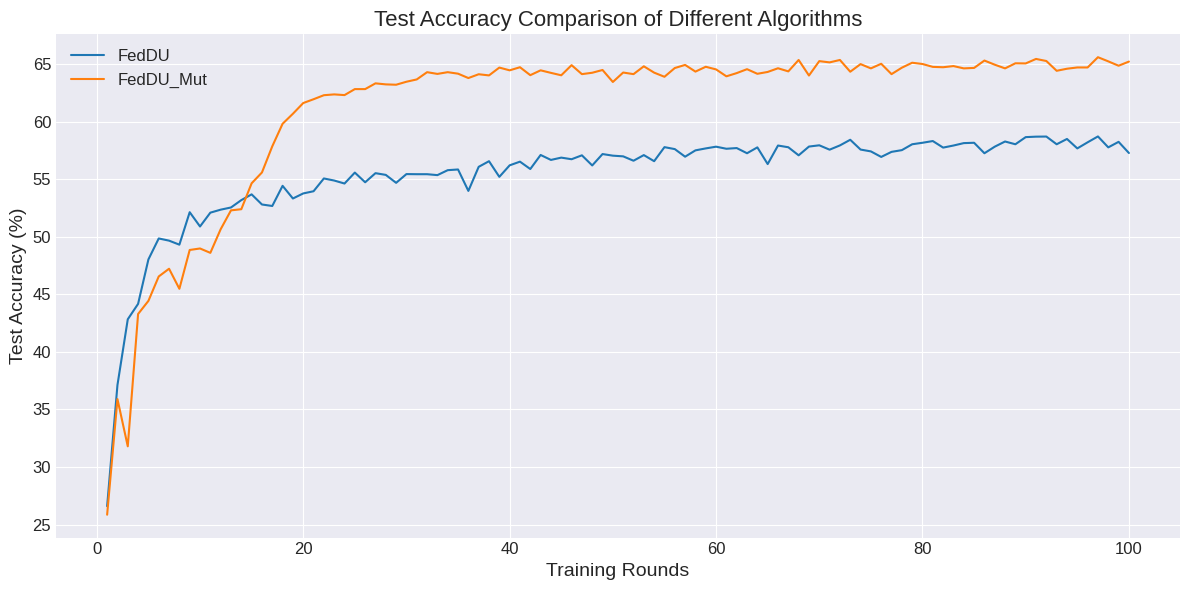

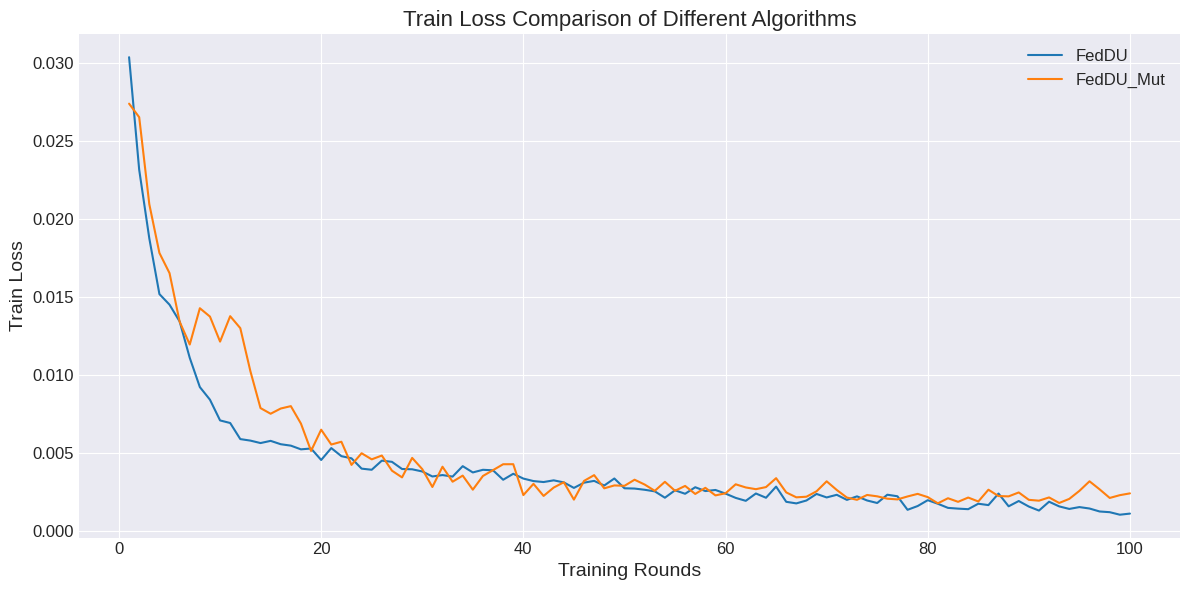

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import platform
import datetime


# 定义训练轮数
rounds = range(1, global_round + 1)

# 设置绘图风格（可选）
plt.style.use('seaborn-v0_8-darkgrid')

# 获取当前时间戳，格式为 YYYYmmdd_HHMMSS
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Plot Test Accuracy Comparison
plt.figure(figsize=(12, 6))
for algo, acc in results_test_acc.items():
    plt.plot(rounds, acc, label=algo)
plt.xlabel('Training Rounds', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.title('Test Accuracy Comparison of Different Algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'output/test_accuracy_{origin_model}_{timestamp}.png')  # 保存图像
plt.show()


# Plot Train Loss Comparison
plt.figure(figsize=(12, 6))
for algo, loss in results_train_loss.items():
    plt.plot(rounds, loss, label=algo)
plt.xlabel('Training Rounds', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)
plt.title('Train Loss Comparison of Different Algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'output/train_loss_{origin_model}_{timestamp}.png')  # 保存图像
plt.show()